# Fashion Recommendation System

In [153]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
from keras.applications import VGG16
from keras.preprocessing import image
from keras.layers import GlobalMaxPooling2D
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from keras.applications.vgg16 import preprocess_input

In [152]:
class FashionRecommendations:
    """ Production class for recommendations of fashion from similarity """
    model=None

    def __init__(self, img_path, df_embeddings, styles_path):
        self.img_path = img_path
        self.df_embeddings = df_embeddings
        self.styles_path = styles_path
        model=self.load_model()

    def get_styles_df(self,nrows=6000):
        """ Load a dataframe contains styles details and images """
        styles_df = pd.read_csv(self.styles_path, nrows=nrows, on_bad_lines='skip') # Read 6000 product and drop bad lines
        styles_df['image'] = styles_df.apply(lambda x: str(x['id']) + ".jpg", axis=1) # Make image column contains (id.jpg)
        return styles_df

    def load_model(self):
        """ Load our model """
        vgg16 = VGG16(include_top=False, weights='imagenet', input_shape=(100, 100, 3))
        vgg16.trainable=False
        vgg16_model = keras.Sequential([vgg16, GlobalMaxPooling2D()])
        return vgg16_model

    def predict(self, img_path):
        """ Load and preprocess image then make prediction """
        # Reshape
        img = image.load_img(self.img_path, target_size=(100, 100))
        # img to Array
        img = image.img_to_array(img)
        # Expand Dim (1, w, h)
        img = np.expand_dims(img, axis=0)
        # Pre process Input
        img = preprocess_input(img)
        return model.predict(img)


    def get_similarity(self):
        """ Get similarity of custom image """
        model = self.load_model()
        df_embeddings = self.df_embeddings
        sample_image = self.predict(self.img_path)
        df_sample_image = pd.DataFrame(sample_image)
        sample_similarity = linear_kernel(df_sample_image, df_embeddings)
        return sample_similarity

    def normalize_sim(self):
        """ Normalize similarity results """
        similarity = self.get_similarity()
        x_min = similarity.min(axis=1)
        x_max = similarity.max(axis=1)
        norm = (similarity-x_min)/(x_max-x_min)[:, np.newaxis]
        return norm

    def get_embeddings(self,df):
      """ Return a dataframe contains images features """
      df_copy = df
      df_embeddings = df_copy['image'].apply(lambda x: self.predict(x).reshape(-1))
      df_embeddings = df_embeddings.apply(pd.Series)
      return df_embeddings


    def get_recommendations(self):
        """ Get recommended images """
        similarity = self.normalize_sim()
        df = self.get_styles_df()
        # Get the pairwsie similarity scores of all clothes with that one (index, value)
        sim_scores = list(enumerate(similarity[0]))

        # Sort the clothes based on the similarity scores
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

        # Get the scores of the 5 most similar clothes
        sim_scores = sim_scores[0:5]
        print(sim_scores)
        # Get the clothes indices
        cloth_indices = [i[0] for i in sim_scores]

        # Return the top 5 most similar products
        return df['image'].iloc[cloth_indices]

    def print_recommendations(self):
      """ Print the top 5 most similar products """
      recommendation = self.get_recommendations()
      recommendation_list = recommendation.to_list()
      plt.figure(figsize=(20, 20))
      j = 0
      for i in recommendation_list:
          img_path = os.path.join(image_files_folder, i)
          if os.path.isfile(img_path):  # Check if the file exists
              plt.subplot(6, 10, j + 1)
              cloth_img = mpimg.imread(img_path)
              plt.imshow(cloth_img)
              plt.axis("off")
          else:
              print(f"Warning: File not found - {img_path}")
          j += 1
      plt.title("Recommended images", loc='left')
      plt.subplots_adjust(wspace=-0.5, hspace=1)
      plt.show()
      return

(-0.5, 59.5, 79.5, -0.5)

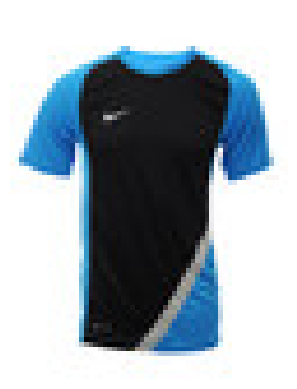

In [154]:
styles_path = '/content/fashion_images/styles.csv'
image_files_folder = '/content/fashion_images/images/'
image_id="10005"
img_path = os.path.join(image_files_folder, image_id+".jpg")

cloth_img = mpimg.imread(img_path)
plt.imshow(cloth_img)
plt.axis("off")

In [155]:
# Load the VGG16 model
recommendation_system = FashionRecommendations(img_path=img_path, df_embeddings=None, styles_path=styles_path)
model = recommendation_system.load_model()

In [156]:
# Load styles DataFrame
styles_df = recommendation_system.get_styles_df().sort_values(by='id').reset_index(drop=True)
# Filter out rows where the image file does not exist
styles_df['file_exists'] = styles_df['image'].apply(lambda x: os.path.isfile(os.path.join(image_files_folder, x)))
styles_df = styles_df[styles_df['file_exists']]
# Drop the 'file_exists' column as it's no longer needed
styles_df = styles_df.drop(columns=['file_exists'])

styles_df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
936,9695,Men,Apparel,Topwear,Tshirts,White,Fall,2011,Casual,Classic Polo Men Vulcan White Polo Tshirts,9695.jpg
961,10000,Women,Apparel,Bottomwear,Skirts,White,Summer,2011,Casual,Palm Tree Girls Sp Jace Sko White Skirts,10000.jpg
962,10001,Women,Apparel,Bottomwear,Skirts,Blue,Summer,2011,Casual,Palm Tree Kids Girls Sp Jema Skt Blue Skirts,10001.jpg
963,10006,Men,Apparel,Topwear,Tshirts,Black,Fall,2011,Sports,Nike Men AS T90 Black Tshirts,10006.jpg
964,10007,Women,Apparel,Topwear,Tshirts,White,Fall,2011,Sports,Nike Women As Trophy Swo White T-Shirts,10007.jpg


In [157]:
df_embeddings = recommendation_system.get_embeddings(styles_df)
recommendation_system.df_embeddings=df_embeddings
df_embeddings

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 722ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
936,0.0,0.0,0.0,0.0,0.0,0.0,4.366094,0.0,0.0,0.0,...,0.0,57.387684,0.0,0.0,33.595001,0.0,0.0,11.87759,0.0,0.0
961,0.0,0.0,0.0,0.0,0.0,0.0,4.366094,0.0,0.0,0.0,...,0.0,57.387684,0.0,0.0,33.595001,0.0,0.0,11.87759,0.0,0.0
962,0.0,0.0,0.0,0.0,0.0,0.0,4.366094,0.0,0.0,0.0,...,0.0,57.387684,0.0,0.0,33.595001,0.0,0.0,11.87759,0.0,0.0
963,0.0,0.0,0.0,0.0,0.0,0.0,4.366094,0.0,0.0,0.0,...,0.0,57.387684,0.0,0.0,33.595001,0.0,0.0,11.87759,0.0,0.0
964,0.0,0.0,0.0,0.0,0.0,0.0,4.366094,0.0,0.0,0.0,...,0.0,57.387684,0.0,0.0,33.595001,0.0,0.0,11.87759,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1068,0.0,0.0,0.0,0.0,0.0,0.0,4.366094,0.0,0.0,0.0,...,0.0,57.387684,0.0,0.0,33.595001,0.0,0.0,11.87759,0.0,0.0
1617,0.0,0.0,0.0,0.0,0.0,0.0,4.366094,0.0,0.0,0.0,...,0.0,57.387684,0.0,0.0,33.595001,0.0,0.0,11.87759,0.0,0.0
1618,0.0,0.0,0.0,0.0,0.0,0.0,4.366094,0.0,0.0,0.0,...,0.0,57.387684,0.0,0.0,33.595001,0.0,0.0,11.87759,0.0,0.0
1619,0.0,0.0,0.0,0.0,0.0,0.0,4.366094,0.0,0.0,0.0,...,0.0,57.387684,0.0,0.0,33.595001,0.0,0.0,11.87759,0.0,0.0


In [158]:
# Generate embeddings and save to CSV
df_embeddings.to_csv('/content/fashion_images/precomputed_embeddings.csv', index=False)

# Load precomputed embeddings
df_embeddings = pd.read_csv('/content/fashion_images/precomputed_embeddings.csv')

df_embeddings.head()
print("Embeddings shape:", df_embeddings.shape)

Embeddings shape: (113, 512)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
[(56, 1.0), (0, 0.0), (1, 0.0), (2, 0.0), (3, 0.0)]


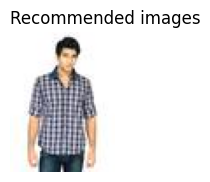

In [159]:
# Print recommendations
recommendation_system.print_recommendations()